In [1]:
import sys
import os
import math
from batchnorm import SynchronizedBatchNorm2d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
from torchvision import transforms as tsf
import scipy.misc

from pathlib import Path

from PIL import Image
import skimage
from skimage import io
import skimage.transform
import PIL
import imageio
from IPython.display import clear_output

TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline
BatchNorm2d = SynchronizedBatchNorm2d

In [2]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2] > 3:
            assert(img[:,:,3] != 255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path / (item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data
test = process('test/images/')
t.save(test, TEST_PATH)
train_data = process('train/images', "train/1st_manual/")

/home/ubuntu/miniconda3/lib/python3.7/site-packages/imageio/plugins/_tifffile.py:8388: UserWarning: unexpected end of LZW stream (code 0)
  warnings.warn('unexpected end of LZW stream (code %i)' % code)


In [3]:
class Dataset():
    def __init__(self, data, source_transform, target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128, 128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5, 0.5, 0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128, 128), interpolation=PIL.Image.NEAREST),
    tsf.ToTensor()]
)
dataset = Dataset(train_data, s_trans, t_trans)

In [32]:
X_train = [dataset[i] for i in range (0, 20)]

In [5]:
class RotatedDataset():
    def __init__(self, data, angle):
        self.datas = data
        self.angle = angle
        self.s_transform = tsf.Compose([
            tsf.ToPILImage(),
            tsf.Lambda(lambda x: tsf.functional.affine(x, self.angle,
                                                       translate=(0, 0), scale=1, 
                                                       shear = False)),
            tsf.Resize((128, 128)),
            tsf.ToTensor(),
            tsf.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]),
        ])
        self.t_transform = t_trans = tsf.Compose([
            tsf.ToPILImage(),
            tsf.Lambda(lambda x: tsf.functional.affine(x, self.angle,
                                                       translate=(0, 0), scale=1,
                                                       shear = False)),
            tsf.Resize((128, 128), interpolation=PIL.Image.NEAREST),
            tsf.ToTensor()
        ])
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)

In [35]:
for angle in range(90, 360, 90):
    rotated_dataset = RotatedDataset(train_data, angle)
    for i in range(0, 20):
        X_train.append(rotated_dataset[i])

In [36]:
len(X_train)

80

In [42]:
dtype=t.FloatTensor

def _epoch(network, loss, loader, optimizer):
    losses = []
    for X, y in loader:
        X = X.type(dtype)
        prediction = network(X)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.item())
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
    return losses

def train(network, train_loader, epochs, learning_rate, loss):
    optimizer = t.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    network = network.train()
    for epoch in range(epochs):
        losses = _epoch(network, loss, train_loader, optimizer)
        train_loss_epochs.append(np.mean(losses))
        clear_output(True)
        print('Epoch {0}... Loss: {1:.3f}'.format(
                    epoch, train_loss_epochs[-1]))
        plt.figure(figsize=(12, 5))
        plt.plot(train_loss_epochs)
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.grid()
        plt.show()
    return train_loss_epochs

In [39]:
import torch.nn as nn
BatchNorm2d = SynchronizedBatchNorm2d

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 128
        super(ResNet, self).__init__()
        self.conv1 = conv3x3(3, 64, stride=2)
        self.bn1 = BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(64, 64)
        self.bn2 = BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = conv3x3(64, 128)
        self.bn3 = BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(3, stride=1)
        self.fc = nn.Linear(512 * 4, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = t.nn.functional.sigmoid(x)

        return x

def resnet18(**kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

In [17]:
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1) + 1) / (m1.sum(1) + m2.sum(1) + 1)
        score = 1 - score.sum()/num
        return score

In [47]:
train_loader = t.utils.data.DataLoader(X_train, batch_size=4, shuffle=True)

Epoch 9... Loss: -0.999


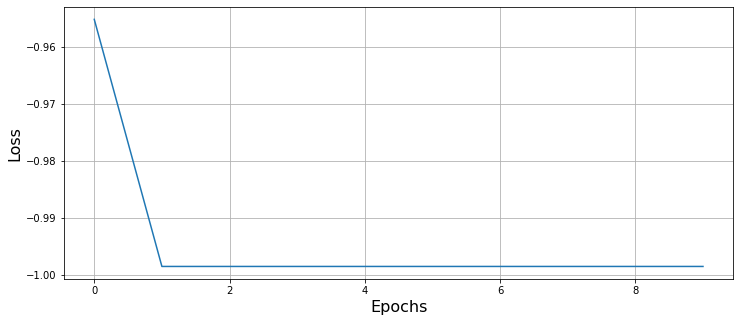

[-0.9551922678947449,
 -0.99855877161026,
 -0.998558783531189,
 -0.9985587775707245,
 -0.9985587775707245,
 -0.998558759689331,
 -0.998558759689331,
 -0.998558783531189,
 -0.9985587775707245,
 -0.9985587656497955]

In [49]:
model = resnet18(num_classes=1)
train(model, train_loader, 10, 0.01, soft_dice_loss)

In [50]:
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128, 128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [51]:
#os.makedirs("resnet_result")

In [52]:
model = model.eval()
for ex_id, data in enumerate(testdataloader):
    data = t.autograd.Variable(data, volatile=True)
    o = model(data)
    
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)
    
    imageio.imwrite("resnet_result/%s.png" % (ex_id + 1), tm)

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


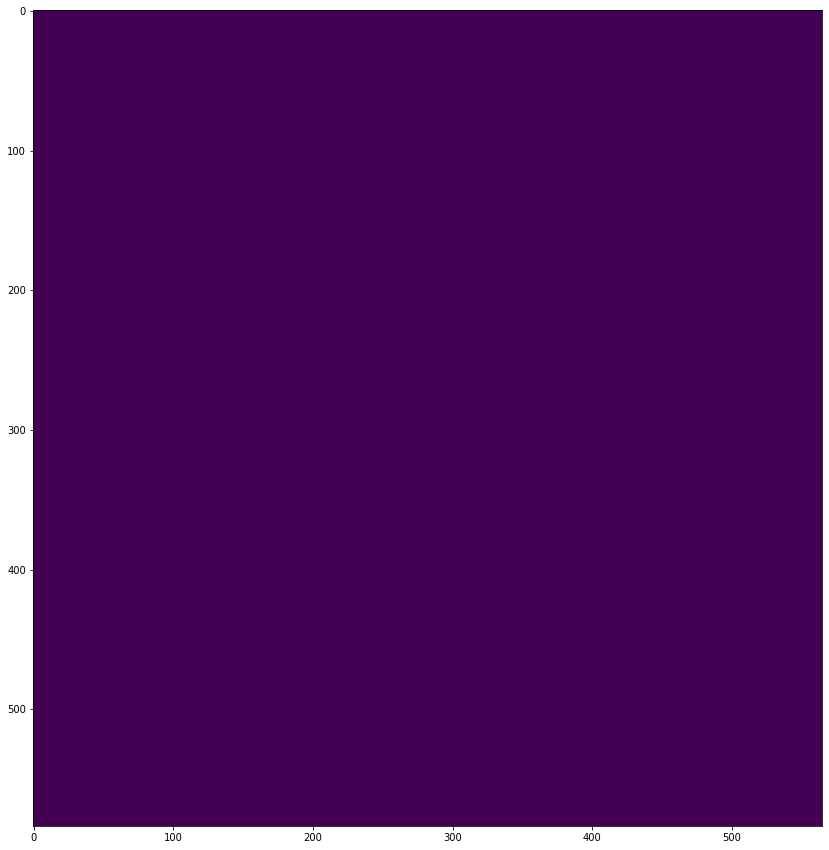

In [53]:
plt.figure(figsize=(15, 15))
plt.imshow(tm)